# Dataset: Sunspots

## 1. Import the dataset and libraries

In [120]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [121]:
import numpy as np
import matplotlib.pyplot as plt

In [122]:
# Import the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Bidirectional, Lambda
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.backend import clear_session

### Plot time series function


In [123]:
# Plot time series function
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [124]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
  -O /tmp/sunspots.csv

--2020-10-29 19:13:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-10-29 19:13:47 (120 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



### Read the data

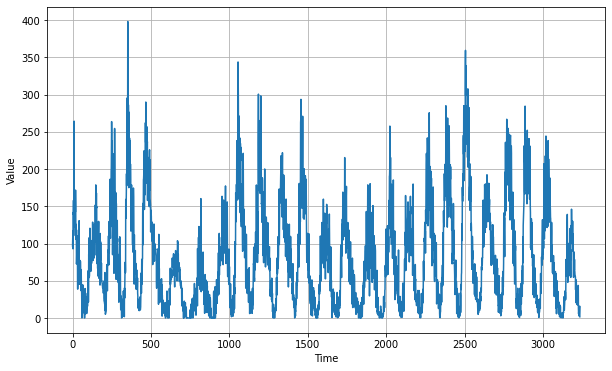

In [125]:
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile: 
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)

  for row in reader: 
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

### Define the constants

In [126]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [127]:
x_train

array([ 96.7, 104.3, 116.7, ...,  78.5,  97.3, 119.2])

## 2. Preprocess the data

In [128]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [129]:
dataset

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>

In [130]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


## 3. Create the model

In [135]:
model = tf.keras.models.Sequential([
                                    Conv1D(filters=60, kernel_size=5, 
                                           strides=1, 
                                           padding="causal", 
                                           activation='relu', 
                                           input_shape=[None, 1]),
                                    
                                    LSTM(32, return_sequences=True), 
                                    LSTM(32, return_sequences=True),
                                    
                                    Dense(30, activation="relu"), 
                                    Dense(10, activation="relu"),
                                    Dense(1),

                                    Lambda(lambda x: x*400)
])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-8*10**(epoch / 20))
optimizer = SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          11904     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dense_6 (Dense)              (None, None, 30)          990       
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)          

In [136]:
# Train the model
history = model.fit(train_set, epochs=500)

Epoch 1/500
92/92 [==============================] - 1s 11ms/step - loss: 26.3703 - mae: 26.8648
Epoch 2/500
92/92 [==============================] - 1s 11ms/step - loss: 21.0418 - mae: 21.5347
Epoch 3/500
92/92 [==============================] - 1s 11ms/step - loss: 19.1555 - mae: 19.6479
Epoch 4/500
92/92 [==============================] - 1s 11ms/step - loss: 18.8923 - mae: 19.3842
Epoch 5/500
92/92 [==============================] - 1s 11ms/step - loss: 18.2914 - mae: 18.7834
Epoch 6/500
92/92 [==============================] - 1s 11ms/step - loss: 18.4008 - mae: 18.8929
Epoch 7/500
92/92 [==============================] - 1s 11ms/step - loss: 17.8744 - mae: 18.3663
Epoch 8/500
92/92 [==============================] - 1s 11ms/step - loss: 17.7107 - mae: 18.2021
Epoch 9/500
92/92 [==============================] - 1s 11ms/step - loss: 17.6715 - mae: 18.1624
Epoch 10/500
92/92 [==============================] - 1s 11ms/step - loss: 17.5074 - mae: 17.9986
Epoch 11/500
92/92 [=========

## 4. Do the prediction

## Forecast function

In [138]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [139]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

### Evaluate the model

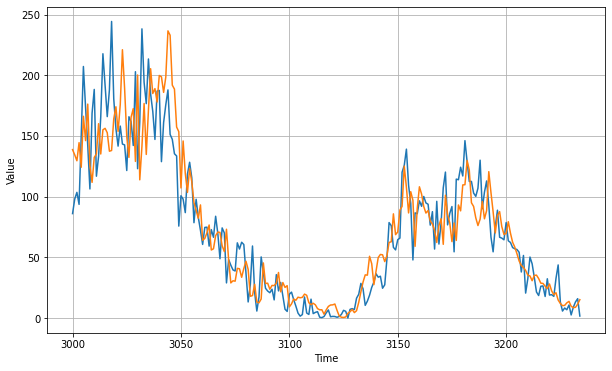

In [140]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [141]:
# Get the mean_absolute_error
mean_absolute_error(x_valid, results).numpy()

30.799145

<Figure size 432x288 with 0 Axes>

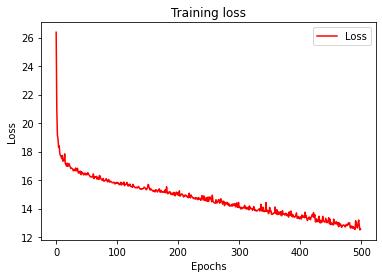

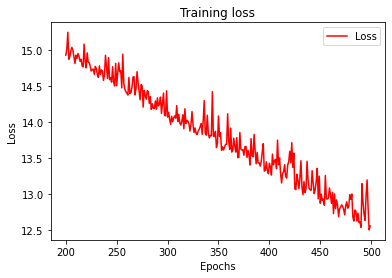

<Figure size 432x288 with 0 Axes>

In [142]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()